# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Нужно построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста.

План работы:
1. Загрузить и проверить данные
2. Сделать аугментацию
3. Подобрать нейросеть для решения задачи
4. Обучить нейросеть и подобрать лучшие параметры
5. Проанализировать полученный результат

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

Загрузим данные

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=1224) 

Found 7591 validated image filenames.


([], [])

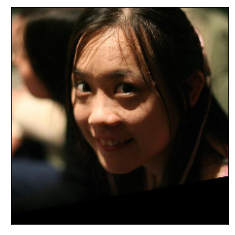

In [3]:
generated_image = gen_flow[0][0][0]
plt.imshow(generated_image)
plt.xticks([])
plt.yticks([])

Посмотрим на общую информацию о предоставленных данных

In [4]:
def info(data, name):
    """ Input: data = имя файла
               name = название файла 
        Output: none
        Description: Функция выводит на экран общую информацию файла,
        количесво дубликатов в файле, количесво пропусков в файле
    """
    start = "\033[1m"
    end = "\033[0;0m"
    print(start + "Общая информация", name + end)
    print(data.info())
    print(start + name + end)
    display(data)
    print(start + "Cтатистические данные", name + end)
    display(data.describe())
    print(start + "Количесво дубликатов", name + end)
    print(data.duplicated().sum())
    print(start + "Количесво пропусков", name + end)
    display(data.isna().sum())

In [5]:
info(labels, "Фотографии")

Общая информация Фотографии
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
Фотографии


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


Cтатистические данные Фотографии


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Количесво дубликатов Фотографии
0
Количесво пропусков Фотографии


file_name    0
real_age     0
dtype: int64

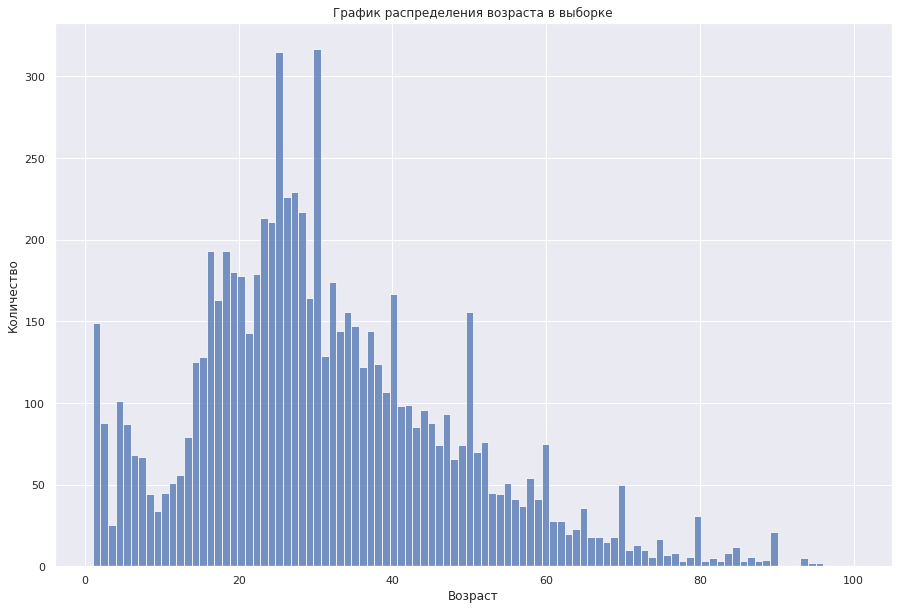

In [12]:
sns.histplot(labels["real_age"], bins=100)
sns.set(rc={"figure.figsize":(20,10)})
plt.title("График распределения возраста в выборке")
plt.xlabel("Возраст")
plt.ylabel("Количество")
plt.show()

Как мы видим из гистограммы , больше всего фотографий людей в возрасте от 18 до 40 лет. Также, присутствует большое количество фотографий детей. Отметим всплески в круглые даты (30, 40 …) и 25 лет, возможно связаны с особенностью разметки базы данных. 

In [7]:
sorted(labels["real_age"].unique())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 93,
 94,
 95,
 96,
 97,
 100]

In [8]:
features, target = next(gen_flow)
print("Размер фотографий", features.shape)

Размер фотографий (32, 224, 224, 3)


База данных содержит 7 591 фотографию. Фотографии были собраны с помощью веб-приложения. Пользователей спросили
загружать фотографию одного человека. Изображения и их реальные и кажущиеся голоса, собранные из разработанного приложения были объединены с пожертвованными на платформе AgeGuess. Кроме того, для увеличения размера базы данных, дополнительные фотографии из Интернета были загружены в AMT и отмечены многими пользователями.


Послез загрузки данных мы видим:
- Данные содержат 7591 строку и 2 колонки "file_name" - имя файла фотографии,  "real_age" - реальный возраст человека на фотографии
- Дубликатов и пропусков не обнаружено
- На фотографиях люди в возрасте от 1 года до 100 лет
- Большинство фотографий принадлежат людям в возрасте от 20 до 41 года
- Также видим большое количество фотографий детей 
- Отсутствуют фотографии людей в возрасте 92, 98 и 99 лет

Посмотрим на фотографии людей старше 80 лет

In [9]:
# Создадим отдельную выборку с фотографиями людей страше 80 лет
age_over_80 = labels.query("real_age > 80")
age_over_80 = list(age_over_80["file_name"])

In [ ]:
for i in range(len(age_over_80)):
    image = Image.open('/datasets/faces/final_files/' + age_over_80[i])
    plt.imshow(np.array(image))
    plt.xticks([])
    plt.yticks([])
    plt.show()

Как мы видим фотографии действительно принадлежат людям внешне старше 80 лет

Посмотрим на фотографии детей младше 3х лет

In [10]:
age_down_3 = labels.query('real_age <= 2')
age_down_3 = list(age_down_3['file_name'])

In [ ]:
for i in range(len(age_down_3)):
    image = Image.open('/datasets/faces/final_files/' + age_down_3[i])
    plt.imshow(np.array(image))
    plt.xticks([])
    plt.yticks([])
    plt.show()

Как мы видим фотографии действительно принадлежат детям внешне младше 3 лет

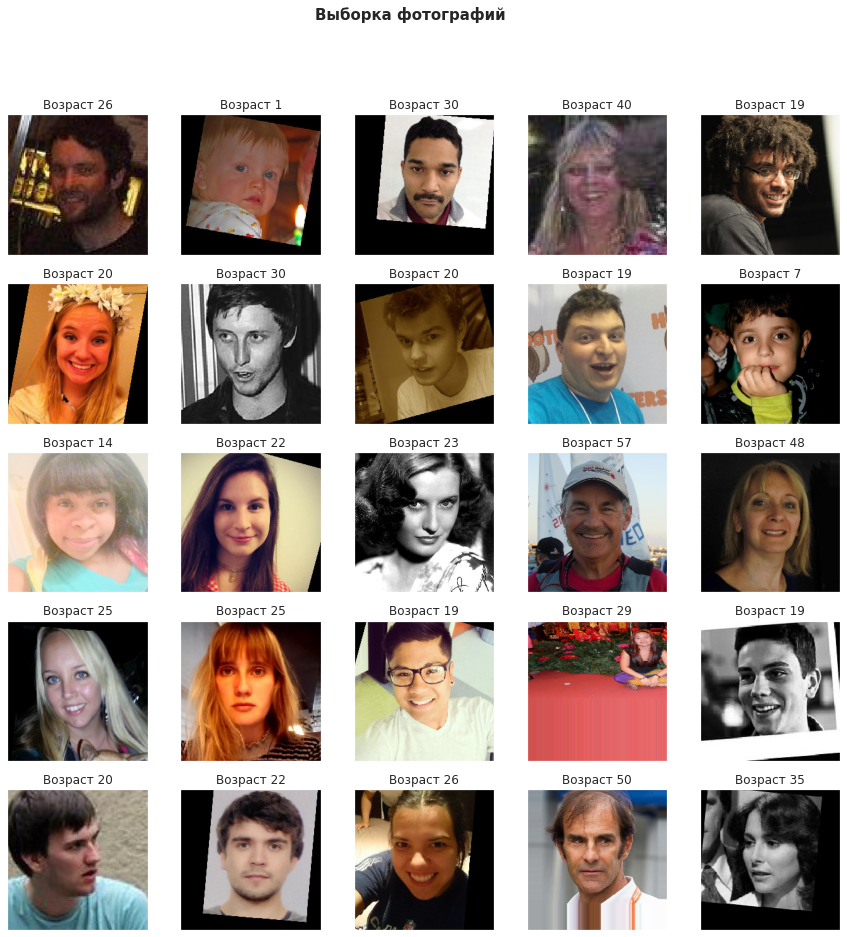

In [11]:
fig = plt.figure(figsize=(15,15))
fig.suptitle("Выборка фотографий", fontsize=15, fontweight='bold')
for i in range(25):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.title(f"Возраст {target[i]}")
    plt.xticks([])
    plt.yticks([])

### Вывод

Для обучения модели взята база фотографий MORPH-Album. База данных содержит 7 591 фотографию. Фотографии были собраны с помощью веб-приложения. Пользователей спросили загружать фотографию одного человека. Фотографии и их реальный и кажущейся возраст, собранные из разработанного приложения были объединены с пожертвованными на платформе AgeGuess. Кроме того, для увеличения размера базы данных, дополнительные фотографии из Интернета были загружены в AMT и отмечены многими пользователями.

В ходе анализа мы выяснили, что присутствуют фотографии как хорошего качества, так и очень плохого, есть черно-белые, с поворотом по оси.  Присутствуют фотографии людей в очках, головных уборах и прикрытыми частями лица. Что должно сказаться хорошо на обучении модели, т.к. мы не знаем как будут одеты и на сколько будут статичны люди во время сьемки в прикассовой зоне. 

Больше всего фотографий людей в возрасте от 18 до 40 лет, Также, присутствует большое количество фотографий детей, что возможно связано с созданием базы данных. Отметим что всплески в круглые даты (30, 40 …) возможно связаны с особенностью разметки база данных. 

Перед обучением можно добавить аугментации для группы людей страше 60 лет

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

### ResNet50

```python

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam


def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
            validation_split=0.25,
            rescale=1./255,
            horizontal_flip=True,
            width_shift_range=0.2,
            height_shift_range=0.2,
            brightness_range=[0.2,1.0],
#             zoom_range=[0.5,1.0]
    )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=1224)
    
    return train_datagen_flow


def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
       )
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=1224)
    
    return test_datagen_flow


def create_model(input_shape):
    
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)  

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, 
                batch_size=32, 
                epochs=45,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 
>

```

```

Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/45
178/178 - 131s - loss: 236.4162 - mae: 11.0395 - val_loss: 898.6665 - val_mae: 25.0343
Epoch 2/45
178/178 - 101s - loss: 93.7892 - mae: 7.2698 - val_loss: 793.1256 - val_mae: 23.0365
Epoch 3/45
178/178 - 101s - loss: 73.7254 - mae: 6.5546 - val_loss: 274.0359 - val_mae: 11.9621
Epoch 4/45
178/178 - 101s - loss: 61.7225 - mae: 6.0995 - val_loss: 141.7955 - val_mae: 9.1443
Epoch 5/45
178/178 - 101s - loss: 52.4446 - mae: 5.5131 - val_loss: 82.2295 - val_mae: 6.7547
Epoch 6/45
178/178 - 101s - loss: 45.8230 - mae: 5.1780 - val_loss: 82.5402 - val_mae: 6.6782
Epoch 7/45
178/178 - 101s - loss: 43.0560 - mae: 5.0152 - val_loss: 90.5072 - val_mae: 7.2240
Epoch 8/45
178/178 - 101s - loss: 41.8372 - mae: 4.9327 - val_loss: 97.7716 - val_mae: 7.5001
Epoch 9/45
178/178 - 102s - loss: 34.1665 - mae: 4.4374 - val_loss: 78.4272 - val_mae: 6.5710
Epoch 10/45
178/178 - 101s - loss: 29.0260 - mae: 4.1323 - val_loss: 70.3244 - val_mae: 6.1797
Epoch 11/45
178/178 - 101s - loss: 24.2466 - mae: 3.7945 - val_loss: 70.1075 - val_mae: 6.3094
Epoch 12/45
178/178 - 102s - loss: 23.1382 - mae: 3.7025 - val_loss: 81.9228 - val_mae: 6.8178
Epoch 13/45
178/178 - 101s - loss: 22.0981 - mae: 3.5998 - val_loss: 78.2701 - val_mae: 6.5568
Epoch 14/45
178/178 - 101s - loss: 19.6367 - mae: 3.4225 - val_loss: 66.3624 - val_mae: 5.9137
Epoch 15/45
178/178 - 101s - loss: 17.9489 - mae: 3.2517 - val_loss: 66.7648 - val_mae: 6.1148
Epoch 16/45
178/178 - 102s - loss: 15.3665 - mae: 3.0441 - val_loss: 66.8904 - val_mae: 5.9721
Epoch 17/45
178/178 - 102s - loss: 15.4531 - mae: 3.0461 - val_loss: 93.2603 - val_mae: 7.2985
Epoch 18/45
178/178 - 102s - loss: 15.8572 - mae: 3.0439 - val_loss: 81.1827 - val_mae: 6.5110
Epoch 19/45
178/178 - 101s - loss: 13.8353 - mae: 2.8563 - val_loss: 73.2102 - val_mae: 6.0163
Epoch 20/45
178/178 - 101s - loss: 14.0866 - mae: 2.8647 - val_loss: 77.3651 - val_mae: 6.3688
Epoch 21/45
178/178 - 101s - loss: 13.2109 - mae: 2.7743 - val_loss: 66.8629 - val_mae: 5.8594
Epoch 22/45
178/178 - 101s - loss: 12.0657 - mae: 2.6655 - val_loss: 65.9731 - val_mae: 5.9656
Epoch 23/45
178/178 - 101s - loss: 13.1675 - mae: 2.7467 - val_loss: 81.5327 - val_mae: 6.4883
Epoch 24/45
178/178 - 101s - loss: 12.4380 - mae: 2.6869 - val_loss: 71.4053 - val_mae: 6.4191
Epoch 25/45
178/178 - 102s - loss: 11.1451 - mae: 2.5615 - val_loss: 69.2565 - val_mae: 6.0980
Epoch 26/45
178/178 - 101s - loss: 11.5630 - mae: 2.6187 - val_loss: 64.9555 - val_mae: 6.0784
Epoch 27/45
178/178 - 102s - loss: 11.0449 - mae: 2.5274 - val_loss: 62.4459 - val_mae: 5.7896
Epoch 28/45
178/178 - 101s - loss: 10.0532 - mae: 2.4450 - val_loss: 65.4729 - val_mae: 6.1731
Epoch 29/45
178/178 - 101s - loss: 10.3242 - mae: 2.4368 - val_loss: 66.7852 - val_mae: 5.9590
Epoch 30/45
178/178 - 102s - loss: 10.7905 - mae: 2.5333 - val_loss: 60.6851 - val_mae: 5.7270
Epoch 31/45
178/178 - 102s - loss: 9.9638 - mae: 2.4069 - val_loss: 79.1335 - val_mae: 6.6480
Epoch 32/45
178/178 - 101s - loss: 10.2132 - mae: 2.4567 - val_loss: 62.9533 - val_mae: 5.7513
Epoch 33/45
178/178 - 101s - loss: 9.6626 - mae: 2.3593 - val_loss: 63.6160 - val_mae: 5.9346
Epoch 34/45
178/178 - 102s - loss: 9.8918 - mae: 2.3702 - val_loss: 74.7722 - val_mae: 6.2825
Epoch 35/45
178/178 - 101s - loss: 9.3266 - mae: 2.3278 - val_loss: 67.0957 - val_mae: 6.0913
Epoch 36/45
178/178 - 101s - loss: 9.0380 - mae: 2.2975 - val_loss: 62.1512 - val_mae: 5.8628
Epoch 37/45
178/178 - 102s - loss: 8.0436 - mae: 2.1887 - val_loss: 65.8235 - val_mae: 5.8700
Epoch 38/45
178/178 - 102s - loss: 9.1958 - mae: 2.2860 - val_loss: 65.5806 - val_mae: 5.9812
Epoch 39/45
178/178 - 102s - loss: 8.8038 - mae: 2.2552 - val_loss: 77.3165 - val_mae: 6.1754
Epoch 40/45
178/178 - 102s - loss: 8.7298 - mae: 2.2636 - val_loss: 68.4681 - val_mae: 5.8709
Epoch 41/45
178/178 - 101s - loss: 8.1545 - mae: 2.1632 - val_loss: 63.9628 - val_mae: 5.7125
Epoch 42/45
178/178 - 102s - loss: 7.8803 - mae: 2.1547 - val_loss: 65.4631 - val_mae: 6.1825
Epoch 43/45
178/178 - 101s - loss: 21.5172 - mae: 3.3483 - val_loss: 118.9875 - val_mae: 7.9016
Epoch 44/45
178/178 - 102s - loss: 14.9966 - mae: 2.9196 - val_loss: 75.4608 - val_mae: 6.4632
Epoch 45/45
178/178 - 102s - loss: 9.5060 - mae: 2.3585 - val_loss: 63.5874 - val_mae: 5.8073
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 63.5874 - mae: 5.8073
Test MAE: 5.8073

```

### ResNet101

```python

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam


def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
            validation_split=0.25,
            rescale=1./255,
            horizontal_flip=True,
            width_shift_range=0.2,
            height_shift_range=0.2,
            brightness_range=[0.2,1.0],
#             zoom_range=[0.5,1.0]
    )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=1224)
    
    return train_datagen_flow


def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
       )
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=1224)
    
    return test_datagen_flow


def create_model(input_shape):
    
    optimizer = Adam(lr=0.0001)
    backbone = ResNet101(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)  

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, 
                batch_size=32, 
                epochs=39,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 


```

```

Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/39
178/178 - 141s - loss: 227.1242 - mae: 10.8743 - val_loss: 1110.8236 - val_mae: 28.6907
Epoch 2/39
178/178 - 101s - loss: 92.4420 - mae: 7.2829 - val_loss: 815.1949 - val_mae: 23.2400
Epoch 3/39
178/178 - 101s - loss: 74.2081 - mae: 6.5530 - val_loss: 280.9723 - val_mae: 12.3177
Epoch 4/39
178/178 - 102s - loss: 60.4200 - mae: 5.9077 - val_loss: 121.3193 - val_mae: 8.1775
Epoch 5/39
178/178 - 101s - loss: 51.8539 - mae: 5.5048 - val_loss: 71.6904 - val_mae: 6.2882
Epoch 6/39
178/178 - 101s - loss: 41.8586 - mae: 4.9726 - val_loss: 93.0762 - val_mae: 7.0461
Epoch 7/39
178/178 - 101s - loss: 40.4355 - mae: 4.8520 - val_loss: 86.0574 - val_mae: 6.7025
Epoch 8/39
178/178 - 101s - loss: 33.3028 - mae: 4.4635 - val_loss: 131.7681 - val_mae: 9.3175
Epoch 9/39
178/178 - 101s - loss: 28.9167 - mae: 4.0992 - val_loss: 76.9809 - val_mae: 6.4761
Epoch 10/39
178/178 - 102s - loss: 26.9645 - mae: 3.9976 - val_loss: 91.5875 - val_mae: 6.7940
Epoch 11/39
178/178 - 101s - loss: 21.8865 - mae: 3.5827 - val_loss: 74.3266 - val_mae: 6.2283
Epoch 12/39
178/178 - 101s - loss: 21.2414 - mae: 3.5750 - val_loss: 74.1151 - val_mae: 6.1073
Epoch 13/39
178/178 - 101s - loss: 18.7606 - mae: 3.3093 - val_loss: 80.7745 - val_mae: 6.4712
Epoch 14/39
178/178 - 102s - loss: 18.2174 - mae: 3.2634 - val_loss: 73.7812 - val_mae: 6.3386
Epoch 15/39
178/178 - 102s - loss: 17.0373 - mae: 3.1542 - val_loss: 80.6147 - val_mae: 6.5142
Epoch 16/39
178/178 - 102s - loss: 14.4419 - mae: 2.9245 - val_loss: 86.9781 - val_mae: 7.2700
Epoch 17/39
178/178 - 101s - loss: 15.5730 - mae: 3.0034 - val_loss: 63.9309 - val_mae: 5.8103
Epoch 18/39
178/178 - 102s - loss: 14.4228 - mae: 2.8512 - val_loss: 76.1099 - val_mae: 6.8657
Epoch 19/39
178/178 - 102s - loss: 13.3345 - mae: 2.7976 - val_loss: 79.0453 - val_mae: 6.2541
Epoch 20/39
178/178 - 101s - loss: 14.6260 - mae: 2.9050 - val_loss: 125.6695 - val_mae: 8.8695
Epoch 21/39
178/178 - 101s - loss: 14.5294 - mae: 2.9327 - val_loss: 70.8293 - val_mae: 6.0431
Epoch 22/39
178/178 - 101s - loss: 12.4493 - mae: 2.6942 - val_loss: 76.3446 - val_mae: 6.4755
Epoch 23/39
178/178 - 101s - loss: 11.8239 - mae: 2.6150 - val_loss: 62.9381 - val_mae: 5.8668
Epoch 24/39
178/178 - 101s - loss: 10.7586 - mae: 2.4627 - val_loss: 67.2557 - val_mae: 6.2257
Epoch 25/39
178/178 - 101s - loss: 9.5557 - mae: 2.3867 - val_loss: 60.1054 - val_mae: 5.7261
Epoch 26/39
178/178 - 101s - loss: 9.0378 - mae: 2.3080 - val_loss: 58.5096 - val_mae: 5.5056
Epoch 27/39
178/178 - 100s - loss: 9.6307 - mae: 2.3585 - val_loss: 71.0234 - val_mae: 5.9256
Epoch 28/39
178/178 - 101s - loss: 8.9223 - mae: 2.2868 - val_loss: 60.4325 - val_mae: 5.7746
Epoch 29/39
178/178 - 101s - loss: 8.3541 - mae: 2.2177 - val_loss: 60.6356 - val_mae: 5.7537
Epoch 30/39
178/178 - 102s - loss: 8.7335 - mae: 2.2621 - val_loss: 61.1173 - val_mae: 5.6253
Epoch 31/39
178/178 - 101s - loss: 9.3456 - mae: 2.3295 - val_loss: 59.0601 - val_mae: 5.6179
Epoch 32/39
178/178 - 102s - loss: 9.5032 - mae: 2.3275 - val_loss: 61.4809 - val_mae: 5.7786
Epoch 33/39
178/178 - 101s - loss: 28.5413 - mae: 3.7026 - val_loss: 93.7738 - val_mae: 7.4807
Epoch 34/39
178/178 - 101s - loss: 39.1878 - mae: 4.6026 - val_loss: 167.2458 - val_mae: 9.5457
Epoch 35/39
178/178 - 101s - loss: 28.8831 - mae: 4.0003 - val_loss: 72.0732 - val_mae: 6.3328
Epoch 36/39
178/178 - 101s - loss: 14.7343 - mae: 2.9351 - val_loss: 59.5931 - val_mae: 5.6118
Epoch 37/39
178/178 - 102s - loss: 10.2486 - mae: 2.4618 - val_loss: 62.1183 - val_mae: 5.9190
Epoch 38/39
178/178 - 101s - loss: 8.9259 - mae: 2.2750 - val_loss: 57.2676 - val_mae: 5.5024
Epoch 39/39
178/178 - 101s - loss: 7.2358 - mae: 2.0751 - val_loss: 55.8625 - val_mae: 5.4864
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 55.8625 - mae: 5.4864
Test MAE: 5.4864

```

### ResNet152

```python

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam


def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
            validation_split=0.25,
            rescale=1./255,
            horizontal_flip=True,
            width_shift_range=0.2,
            height_shift_range=0.2,
            brightness_range=[0.2,1.0],
#             zoom_range=[0.5,1.0]
    )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=1224)
    
    return train_datagen_flow


def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
       )
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=1224)
    
    return test_datagen_flow


def create_model(input_shape):
    
    optimizer = Adam(lr=0.0001)
    backbone = ResNet152(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)  

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, 
                batch_size=32, 
                epochs=45,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 


```

```

Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/45
178/178 - 126s - loss: 226.6796 - mae: 10.8808 - val_loss: 356.1940 - val_mae: 13.9880
Epoch 2/45
178/178 - 103s - loss: 98.2114 - mae: 7.4775 - val_loss: 444.2573 - val_mae: 15.9432
Epoch 3/45
178/178 - 103s - loss: 72.4750 - mae: 6.4889 - val_loss: 152.7063 - val_mae: 9.2566
Epoch 4/45
178/178 - 103s - loss: 62.3223 - mae: 6.0536 - val_loss: 100.9575 - val_mae: 7.4531
Epoch 5/45
178/178 - 103s - loss: 51.0235 - mae: 5.4912 - val_loss: 93.6723 - val_mae: 7.1109
Epoch 6/45
178/178 - 103s - loss: 43.7085 - mae: 5.1265 - val_loss: 70.2663 - val_mae: 6.2815
Epoch 7/45
178/178 - 103s - loss: 38.6969 - mae: 4.7396 - val_loss: 70.8563 - val_mae: 6.2461
Epoch 8/45
178/178 - 103s - loss: 35.3758 - mae: 4.4917 - val_loss: 81.3760 - val_mae: 6.8398
Epoch 9/45
178/178 - 103s - loss: 28.4776 - mae: 4.0886 - val_loss: 68.8355 - val_mae: 6.0128
Epoch 10/45
178/178 - 103s - loss: 24.9375 - mae: 3.8240 - val_loss: 69.4165 - val_mae: 6.1603
Epoch 11/45
178/178 - 103s - loss: 23.2866 - mae: 3.7182 - val_loss: 65.4393 - val_mae: 5.9579
Epoch 12/45
178/178 - 104s - loss: 19.7960 - mae: 3.4307 - val_loss: 68.2566 - val_mae: 6.1129
Epoch 13/45
178/178 - 103s - loss: 20.2956 - mae: 3.4326 - val_loss: 83.7318 - val_mae: 6.7864
Epoch 14/45
178/178 - 103s - loss: 27.1475 - mae: 3.9625 - val_loss: 78.2178 - val_mae: 6.4520
Epoch 15/45
178/178 - 103s - loss: 23.7977 - mae: 3.7504 - val_loss: 68.7866 - val_mae: 6.1333
Epoch 16/45
178/178 - 103s - loss: 18.4086 - mae: 3.3082 - val_loss: 64.0924 - val_mae: 5.9786
Epoch 17/45
178/178 - 103s - loss: 15.5189 - mae: 3.0262 - val_loss: 59.5007 - val_mae: 5.6592
Epoch 18/45
178/178 - 103s - loss: 14.5875 - mae: 2.9339 - val_loss: 70.8761 - val_mae: 6.3364
Epoch 19/45
178/178 - 103s - loss: 12.8092 - mae: 2.7551 - val_loss: 62.1934 - val_mae: 5.8425
Epoch 20/45
178/178 - 102s - loss: 11.4531 - mae: 2.6025 - val_loss: 60.8377 - val_mae: 5.6393
Epoch 21/45
178/178 - 103s - loss: 10.4822 - mae: 2.4894 - val_loss: 61.4084 - val_mae: 5.7052
Epoch 22/45
178/178 - 103s - loss: 10.7273 - mae: 2.5111 - val_loss: 59.8177 - val_mae: 5.7386
Epoch 23/45
178/178 - 103s - loss: 10.1058 - mae: 2.4184 - val_loss: 62.9234 - val_mae: 5.8168
Epoch 24/45
178/178 - 103s - loss: 10.4547 - mae: 2.4609 - val_loss: 62.7374 - val_mae: 5.8084
Epoch 25/45
178/178 - 103s - loss: 9.9606 - mae: 2.4329 - val_loss: 62.6379 - val_mae: 5.7437
Epoch 26/45
178/178 - 103s - loss: 9.5396 - mae: 2.3576 - val_loss: 58.7210 - val_mae: 5.6373
Epoch 27/45
178/178 - 103s - loss: 10.3093 - mae: 2.4447 - val_loss: 66.2632 - val_mae: 5.7612
Epoch 28/45
178/178 - 103s - loss: 11.3177 - mae: 2.5714 - val_loss: 66.2372 - val_mae: 6.1182
Epoch 29/45
178/178 - 103s - loss: 12.2709 - mae: 2.6921 - val_loss: 63.6497 - val_mae: 5.7940
Epoch 30/45
178/178 - 103s - loss: 11.9304 - mae: 2.5901 - val_loss: 70.1793 - val_mae: 6.0089
Epoch 31/45
178/178 - 103s - loss: 13.9481 - mae: 2.8145 - val_loss: 75.2911 - val_mae: 6.2977
Epoch 32/45
178/178 - 103s - loss: 17.9891 - mae: 3.2001 - val_loss: 70.3150 - val_mae: 6.2066
Epoch 33/45
178/178 - 103s - loss: 26.9982 - mae: 3.8575 - val_loss: 87.4564 - val_mae: 6.8820
Epoch 34/45
178/178 - 103s - loss: 27.9831 - mae: 3.9649 - val_loss: 72.3786 - val_mae: 6.2068
Epoch 35/45
178/178 - 103s - loss: 15.7935 - mae: 3.0172 - val_loss: 68.4063 - val_mae: 5.9747
Epoch 36/45
178/178 - 103s - loss: 10.2628 - mae: 2.4796 - val_loss: 62.3106 - val_mae: 5.7249
Epoch 37/45
178/178 - 103s - loss: 8.1752 - mae: 2.1822 - val_loss: 58.8825 - val_mae: 5.5548
Epoch 38/45
178/178 - 103s - loss: 6.7131 - mae: 1.9908 - val_loss: 62.1861 - val_mae: 5.6249
Epoch 39/45
178/178 - 103s - loss: 6.2338 - mae: 1.9340 - val_loss: 58.4836 - val_mae: 5.5309
Epoch 40/45
178/178 - 103s - loss: 5.6604 - mae: 1.8375 - val_loss: 57.2720 - val_mae: 5.4600
Epoch 41/45
178/178 - 103s - loss: 5.6329 - mae: 1.7977 - val_loss: 57.0251 - val_mae: 5.4410
Epoch 42/45
178/178 - 103s - loss: 5.4663 - mae: 1.7686 - val_loss: 59.7968 - val_mae: 5.5831
Epoch 43/45
178/178 - 103s - loss: 5.6096 - mae: 1.7822 - val_loss: 66.1697 - val_mae: 6.0654
Epoch 44/45
178/178 - 102s - loss: 9.4496 - mae: 2.3394 - val_loss: 64.4522 - val_mae: 5.9356
Epoch 45/45
178/178 - 103s - loss: 7.7404 - mae: 2.1089 - val_loss: 62.1435 - val_mae: 5.7013
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 62.1435 - mae: 5.7013
Test MAE: 5.7013

```

## Анализ обученной модели

Были созданы нейронные сети с архитектурой ResNet в 50, 101 и 152 слоя, преобученых на ImageNet. Для всей базы бала использована аугментация: горизонтальное отражение, сдвиги в лево и в право, значения яркости. Использован алгоритм Adam learning_rate = 0.0001

Лучше всего себя показала ResNet101 с обучением в 39 эпох. Показатель **MAE = 5.4864**

Модель хорошо справится с задачей с разделением людей на возрастные группы, но при определении порога возраста при продаже алкоголя, могут возникать ошибки т.к. Задача определения возраста осложняется тем, что одни люди «показывают свой возраст», другие «хорошо скрывают свой возраст», одни «хорошо стареют», а другие «стареют плохо», указывая на то, что люди воспринимают возраст не обязательно в согласии с биологическими особенностями. При этом не исключаем возможности современной пластической хирургии и бьюти сферы услуг. Также интересно отметить, что видимый возраст в среднем больше реального возраста для молодых людей, но ниже для пожилых людей. Это согласуется с усилиями молодых людей выглядеть более зрелыми, в то время как пожилые пытаются выглядеть моложе.